In [137]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler



## This is a simple example shows how lime work and basic intuition

#### 1. See how does LIME interpret the Random Forest Classifier

[important reference](https://nbviewer.jupyter.org/urls/arteagac.github.io/blog/lime.ipynb)

In [89]:
df = pd.read_csv("data.csv")
df.head()

,x1,x2,y
0,14.48,27.10,0
1,13.83,26.85,0
2,13.18,26.70,0
3,12.53,26.50,0
4,11.58,26.25,0


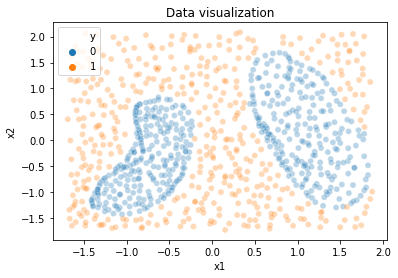

In [92]:
# Standardize the data 
# and visualize the data using scatter plot 
# with labels

scaler = StandardScaler().fit(df[['x1', 'x2']])
df[['x1', 'x2']] = scaler.transform(df[['x1', 'x2']])
plt.title('Data visualization')
sns.scatterplot(data=df, x="x1", y='x2', hue="y",color="0.1", marker="o", alpha= 0.3)
plt.show()

## Import the sklearn package, train the model and make predictions

In [93]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(df[['x1', 'x2']], df.y) 

RandomForestClassifier()

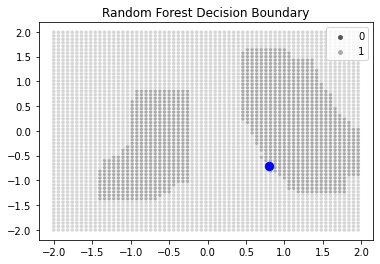

In [98]:
# The following codes will generate data 
# and visualized the decision boundary

xx1, xx2 = np.meshgrid(np.arange(-2, 2, 0.06), np.arange(-2, 2, 0.07))
XX = np.vstack((xx1.ravel(), xx2.ravel())).T

yy = classifier.predict(XX)

# Try to interpret the point Xi
Xi = np.array([0.8,-0.7]) 

sns.scatterplot(x=XX[:,0], y=XX[:,1], hue=yy, palette = "gist_gray",  alpha = 0.5, size= yy, sizes = [15,15])
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )

plt.title('Random Forest Decision Boundary')
plt.show()

## Step 1. Generate random data around the instance being explained

**For the case of sampling data, sampling around the mean and standard deviation of the explanatory variables is recommended. Given that the dataset used in this example was normally standarized in a previous step. To simplify, i randomly generated the data using uniform distribution and classify those randomly generated data using random forest classifier.**




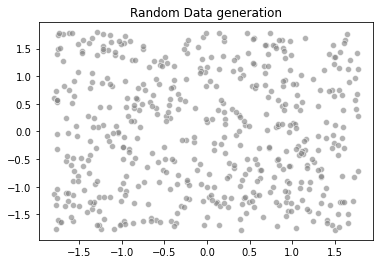

In [99]:
num_perturb = 500

X_lime = np.random.uniform(-1.8,1.8,size=(num_perturb,df.shape[1]-1))

plt.title('Random Data generation')
sns.scatterplot(X_lime[:,0],X_lime[:,1], alpha = 0.6, color = 'grey')
plt.show()


### Step 2: Use ML classifier to predict classes of new generated dataset
**The random forest classifier trained in previous steps is used here to predict the class of each pair (x1,x2) in the new generated dataset.**

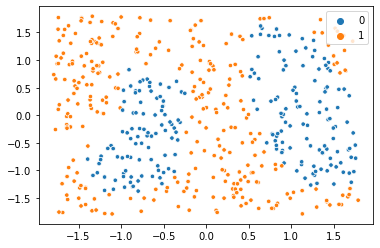

In [83]:

y_lime = classifier.predict(X_lime)

sns.scatterplot(X_lime[:,0],X_lime[:,1],s=20, hue=y_lime)
plt.show()


### Step 3: Compute distances between the instance being explained and each perturbation and compute weights (importance) of the generated instances
The distance between each randomly generated instance and the instance being explained is computed using the euclidean distance. For explanations of other types of data such as image or text data the cosine distance can be used. Such distances are then mapped to a value between zero and one (weight) using a kernel function. Depeding on how we set the kernel width it shows how wide we define the "locality" around our instance. For tabular data the definition of a kernel width needs special atention, specially if the data has not been standarized. A more detailed discussion on this topic of kernel width can be found in the book "Interpretable Machine Learning" by Cristoph Molnar in section 5.7. In the code below, the shape of the weights is shown and it can be noted that for each instance in the new randomly generated dataset, there is a corresponding weight or importance value.

In [100]:
kernel_width = 0.2
distances = np.sum((Xi - X_lime)**2,axis=1) #Euclidean distance
weights = np.sqrt(np.exp(-(distances**2)/(kernel_width**2))) #Kernel function
weights.shape

(500,)

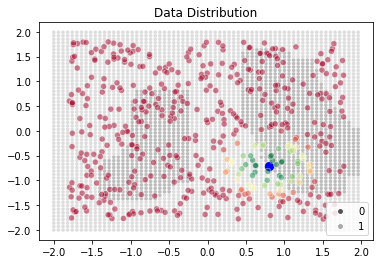

In [118]:
plt.title('Data Distribution')
sns.scatterplot(x=XX[:,0], y=XX[:,1], hue=yy, palette = "gist_gray",  alpha = 0.4, size= yy, sizes = [15,15])
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
sns.scatterplot(X_lime[:,0],X_lime[:,1],hue=weights, palette = "RdYlGn", alpha = 0.5,legend=None)
plt.show()

### Step 4: Use the new generated dataset (X_lime), its class predictions (y_lime) and their importance (weights) to fit simpler and interpretable (linear) model
A linear model is fitted as shown below. This linear model generates new decision boundaries that are locally faitful around the explained instance. This linear decision boundary can be seen with the markers with + and - symbol. It is important to emphasize that this new linear decision boundary is not globally faithful because it is supposed to be a proper discriminator only in the locallity of the instance being explained (blue dot).

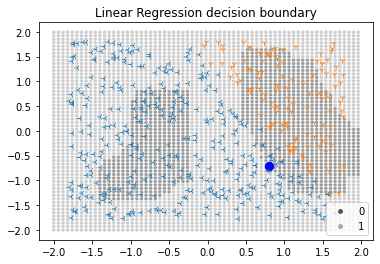

In [131]:
from sklearn.linear_model import LinearRegression
simpler_model = LinearRegression() 
simpler_model.fit(X_lime, y_lime, sample_weight=weights)
y_linmodel = simpler_model.predict(X_lime)
y_linmodel = y_linmodel < 0.5 #Conver to binary class


plt.title('Linear Regression decision boundary')
sns.scatterplot(x=XX[:,0], y=XX[:,1], hue=yy, palette = "gist_gray",  alpha = 0.6, size= yy, sizes = [15,15])
plt.scatter(Xi[0],Xi[1],c="blue",marker="o",s=70 )
sns.scatterplot(X_lime[:,0],X_lime[:,1],hue=y_linmodel, style = y_linmodel,  legend=None, markers= ['3','1'])

plt.show()

The coefficients of this estimated linear model can be used to understand how changes in the explanatoriy variables affect the classification output for the instance being explained. 
For example, as shown below, the estimated coefficients suggest that for the instance being explained, increasing the values of x1 and x2 will cause the prediction to lean towards the prediction of the negative class (darker area).

In [132]:
simpler_model.coef_

array([-0.19624156, -0.11646519])